In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')
sns.set_theme(style='whitegrid', palette='deep')

import os
import mido
import pretty_midi as pm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, Flatten, Conv1D, MaxPooling1D

import tensorflow as tf
# import torch as pt
import joblib
import streamlit as st

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

In [9]:
import os
import pandas as pd
import pretty_midi as pm

# Function to extract all tempos
def extract_all_tempos(file_path):
    midi_data = pm.PrettyMIDI(file_path)
    _, tempos = midi_data.get_tempo_changes()
    return tempos

# Function to extract all velocities
def extract_all_velocities(file_path):
    midi_data = pm.PrettyMIDI(file_path)
    velocities = [note.velocity for instrument in midi_data.instruments for note in instrument.notes]
    return velocities

# Function to load midi files and extract both tempo and velocity features
def load_midi_files_tempos_velocities_to_df(directory_path, composer):
    midi_files = [os.path.join(directory_path, f) for f in os.listdir(directory_path) if f.lower().endswith(('.mid', '.midi'))]
    data = []
    max_tempos = 0  # Track the maximum number of tempo changes in any file
    max_velocities = 0  # Track the maximum number of velocities in any file
    
    for file in midi_files:
        try:
            tempos = extract_all_tempos(file)
            velocities = extract_all_velocities(file)
            max_tempos = max(max_tempos, len(tempos))
            max_velocities = max(max_velocities, len(velocities))
            features = {'composer': composer}
            features.update({f'tempo_{i+1}': tempo for i, tempo in enumerate(tempos)})
            features.update({f'velocity_{i+1}': velocity for i, velocity in enumerate(velocities)})
            data.append(features)
        except Exception as e:
            print(f"Error processing file {file}: {e}")
    
    # Convert the list of dictionaries to a DataFrame
    df = pd.DataFrame(data)
    
    # Ensure all rows have the same number of tempo columns by filling with NaN where necessary
    for i in range(1, max_tempos + 1):
        if f'tempo_{i}' not in df.columns:
            df[f'tempo_{i}'] = pd.NA
    
    # Ensure all rows have the same number of velocity columns by filling with NaN where necessary
    for i in range(1, max_velocities + 1):
        if f'velocity_{i}' not in df.columns:
            df[f'velocity_{i}'] = pd.NA
    
    return df

file_path = 'C:\\Users\\gabri\\OneDrive\\Desktop\\MSAAI\\AAI-511\\aai-511_group1\\midiclassics\\'  # Replace with your actual path
composers = ['Bach', 'Beethoven', 'Chopin', 'Mozart']

# Dictionary to hold DataFrames for each composer
composer_dataframes = {}

random_state = 88

for composer in composers:
    composer_folder = os.path.join(file_path, composer)
    composer_df = load_midi_files_tempos_velocities_to_df(composer_folder, composer)

    if composer == 'Bach':
        composer_df = composer_df.sample(n=250, random_state=random_state)

    composer_dataframes[composer] = composer_df
    print(f"{composer} DataFrame:")
    print(composer_df.head())

# Merge all DataFrames into a single DataFrame
all_composers_df = pd.concat(composer_dataframes.values(), ignore_index=True)

# Separate tempo and velocity columns
tempo_columns = [col for col in all_composers_df.columns if col.startswith('tempo_')]
velocity_columns = [col for col in all_composers_df.columns if col.startswith('velocity_')]

# Apply forward fill to tempo columns
all_composers_df[tempo_columns] = all_composers_df[tempo_columns].T.fillna(method='ffill').T

# Replace NaN in velocity columns with 0
all_composers_df[velocity_columns] = all_composers_df[velocity_columns].fillna(0)

# Display the merged DataFrame
print("Merged DataFrame:")
print(all_composers_df.head())


c:\Users\gabri\anaconda3\envs\tf\lib\site-packages\pretty_midi\pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(


Bach DataFrame:
    composer     tempo_1  velocity_1  velocity_2  velocity_3  velocity_4  \
5       Bach   96.000000          96          96          96          96   
824     Bach   90.044527          88          88          88          88   
352     Bach   96.000000          96          96          96          96   
338     Bach  104.000014          96          96          96          96   
737     Bach   88.000023          96          96          96          96   

     velocity_5  velocity_6  velocity_7  velocity_8  ...  velocity_32995  \
5            96          96          96          96  ...             NaN   
824          88          88          88          88  ...             NaN   
352          96          96          96          96  ...             NaN   
338          96          96          96          96  ...             NaN   
737          96          96          96          96  ...             NaN   

     velocity_32996  velocity_32997  velocity_32998  velocity_32999  \

c:\Users\gabri\anaconda3\envs\tf\lib\site-packages\pretty_midi\pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(


Beethoven DataFrame:
    composer     tempo_1  velocity_1  velocity_2  velocity_3  velocity_4  \
0  Beethoven  236.031833          48          48          48          48   
1  Beethoven  167.999933         108         108         108         111   
2  Beethoven  120.000000          78          80          67          75   
3  Beethoven  109.999908          93         104          97          95   
4  Beethoven  120.000000          66          66          66          66   

   velocity_5  velocity_6  velocity_7  velocity_8  ...  velocity_47736  \
0          45          45          45          45  ...             NaN   
1         111         111         111         111  ...             NaN   
2          78          64          67          80  ...             NaN   
3         101         111         105         103  ...             NaN   
4          64          66          67          69  ...             NaN   

   velocity_47737  velocity_47738  velocity_47739  velocity_47740  \
0       

c:\Users\gabri\anaconda3\envs\tf\lib\site-packages\pretty_midi\pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(


Chopin DataFrame:
  composer     tempo_1  velocity_1  velocity_2  velocity_3  velocity_4  \
0   Chopin  180.000180          80          80          80          80   
1   Chopin  144.053127         105         105         105         105   
2   Chopin  100.031843          85          85          85          85   
3   Chopin  120.007440         100         100         100         100   
4   Chopin   63.003966         100         100         100         100   

   velocity_5  velocity_6  velocity_7  velocity_8  ...  velocity_19920  \
0          80          80          80          80  ...             NaN   
1         105         105         105         105  ...             NaN   
2          85          85          85          85  ...             NaN   
3         100         100         100         100  ...             NaN   
4         100         100         100         100  ...             NaN   

   velocity_19921  velocity_19922  velocity_19923  velocity_19924  \
0             NaN      

c:\Users\gabri\anaconda3\envs\tf\lib\site-packages\pretty_midi\pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(


Error processing file C:\Users\gabri\OneDrive\Desktop\MSAAI\AAI-511\aai-511_group1\midiclassics\Mozart\K281 Piano Sonata n03 3mov.mid: Could not decode key with 2 flats and mode 2
Mozart DataFrame:
  composer     tempo_1     tempo_2     tempo_3     tempo_4  velocity_1  \
0   Mozart  125.000000  116.999889  108.999944  100.000000          64   
1   Mozart   35.999993   36.999991   38.000009   36.999991          77   
2   Mozart  137.999876  123.999992  109.999908   96.000000          64   
3   Mozart  110.000110         NaN         NaN         NaN         127   
4   Mozart  130.000130  129.000077  128.000000  127.000254         127   

   velocity_2  velocity_3  velocity_4  velocity_5  ...  velocity_17841  \
0          64          64          64          64  ...             NaN   
1          77          77         100          82  ...             NaN   
2          64          64          64          64  ...             NaN   
3         127         127         127         127  ...       

In [10]:
all_composers_df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 855 entries, 0 to 854
Data columns (total 51497 columns):
 #      Column          Dtype  
---     ------          -----  
 0      composer        object 
 1      tempo_1         float64
 2      velocity_1      int64  
 3      velocity_2      int64  
 4      velocity_3      int64  
 5      velocity_4      int64  
 6      velocity_5      int64  
 7      velocity_6      int64  
 8      velocity_7      int64  
 9      velocity_8      int64  
 10     velocity_9      int64  
 11     velocity_10     int64  
 12     velocity_11     int64  
 13     velocity_12     int64  
 14     velocity_13     int64  
 15     velocity_14     int64  
 16     velocity_15     int64  
 17     velocity_16     int64  
 18     velocity_17     int64  
 19     velocity_18     int64  
 20     velocity_19     int64  
 21     velocity_20     int64  
 22     velocity_21     int64  
 23     velocity_22     int64  
 24     velocity_23     int64  
 25     velocity_24     int6

In [11]:
all_composers_df.head()

,composer,tempo_1,velocity_1,velocity_2,velocity_3,velocity_4,velocity_5,velocity_6,velocity_7,velocity_8,...,velocity_47736,velocity_47737,velocity_47738,velocity_47739,velocity_47740,velocity_47741,velocity_47742,velocity_47743,velocity_47744,velocity_47745
0,Bach,96.000000,96,96,96,96,96,96,96,96,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Bach,90.044527,88,88,88,88,88,88,88,88,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Bach,96.000000,96,96,96,96,96,96,96,96,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Bach,104.000014,96,96,96,96,96,96,96,96,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Bach,88.000023,96,96,96,96,96,96,96,96,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [12]:
all_composers_df.describe()

,tempo_1,velocity_1,velocity_2,velocity_3,velocity_4,velocity_5,velocity_6,velocity_7,velocity_8,velocity_9,...,velocity_47736,velocity_47737,velocity_47738,velocity_47739,velocity_47740,velocity_47741,velocity_47742,velocity_47743,velocity_47744,velocity_47745
count,855.000000,855.000000,855.000000,855.000000,855.000000,855.000000,855.000000,855.000000,855.000000,855.000000,...,855.000000,855.000000,855.000000,855.000000,855.000000,855.000000,855.000000,855.000000,855.000000,855.000000
mean,114.187439,78.980117,78.409357,78.560234,78.233918,78.355556,78.391813,78.097076,78.039766,77.826901,...,0.056140,0.056140,0.056140,0.056140,0.056140,0.056140,0.056140,0.056140,0.056140,0.056140
std,48.886807,23.279753,23.609001,23.495095,23.252690,23.301554,23.518236,23.585237,23.785011,24.036477,...,1.641565,1.641565,1.641565,1.641565,1.641565,1.641565,1.641565,1.641565,1.641565,1.641565
min,20.000000,22.000000,20.000000,18.000000,24.000000,17.000000,19.000000,26.000000,22.000000,2.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,88.000023,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,104.999921,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,130.000130,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,460.002760,127.000000,127.000000,127.000000,127.000000,127.000000,127.000000,127.000000,127.000000,127.000000,...,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000


In [13]:
has_nan = all_composers_df.isna().any().any()
print(f"Does the DataFrame contain any NaN values? {has_nan}")

Does the DataFrame contain any NaN values? False


In [14]:
total_nan = all_composers_df.isna().sum().sum()
print(f"Total number of NaN values in the DataFrame: {total_nan}")


Total number of NaN values in the DataFrame: 0


In [15]:
nan_per_column = all_composers_df.isna().sum()
print(f"Number of NaN values per column:\n{nan_per_column}")


Number of NaN values per column:
composer          0
tempo_1           0
velocity_1        0
velocity_2        0
velocity_3        0
                 ..
velocity_47741    0
velocity_47742    0
velocity_47743    0
velocity_47744    0
velocity_47745    0
Length: 51497, dtype: int64


In [19]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout


# Separate features (X) and target labels (y)
X = all_composers_df.drop(columns='composer').values
y = all_composers_df['composer'].values

# Encode the composer labels into numeric values
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Normalize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Reshape the data to fit the input shape of a 1D CNN (samples, time steps, features)
X_reshaped = X_scaled.reshape(X_scaled.shape[0], X_scaled.shape[1], 1)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_reshaped, y_encoded, test_size=0.2, random_state=42)


In [20]:
from tensorflow.keras.regularizers import l2

# Define the regularization strength (lambda)
l2_lambda = 0.001  

# Updated model architecture with L2 regularization
model = Sequential([
    Conv1D(64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1), 
           kernel_regularizer=l2(l2_lambda)),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),
    
    Conv1D(128, kernel_size=3, activation='relu', kernel_regularizer=l2(l2_lambda)),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),
    
    Flatten(),
    
    Dense(128, activation='relu', kernel_regularizer=l2(l2_lambda)),
    Dropout(0.3),
    
    Dense(64, activation='relu', kernel_regularizer=l2(l2_lambda)),
    Dropout(0.3),
    
    Dense(len(label_encoder.classes_), activation='softmax', kernel_regularizer=l2(l2_lambda))
])

In [21]:
# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Step 3: Train the Model

history = model.fit(X_train, y_train, epochs=50, validation_split=0.2, batch_size=32, verbose=1)

# Step 4: Evaluate the Model

test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# making predictions and decoding them back to composer names
predictions = model.predict(X_test)
predicted_classes = predictions.argmax(axis=1)
predicted_composers = label_encoder.inverse_transform(predicted_classes)

# Display the first few predictions
for i in range(5):
    print(f"Predicted: {predicted_composers[i]}, Actual: {label_encoder.inverse_transform([y_test[i]])[0]}")


Epoch 1/50
18/18 [==============================] - 19s 1s/step - loss: 8.2702 - accuracy: 0.3016 - val_loss: 4.0102 - val_accuracy: 0.3869
Epoch 2/50
18/18 [==============================] - 18s 1s/step - loss: 3.9396 - accuracy: 0.3510 - val_loss: 3.7660 - val_accuracy: 0.3869
Epoch 3/50
18/18 [==============================] - 18s 1s/step - loss: 3.4714 - accuracy: 0.3967 - val_loss: 3.2489 - val_accuracy: 0.4599
Epoch 4/50
18/18 [==============================] - 18s 1s/step - loss: 3.0172 - accuracy: 0.4461 - val_loss: 2.8859 - val_accuracy: 0.3650
Epoch 5/50
18/18 [==============================] - 18s 1s/step - loss: 2.6692 - accuracy: 0.4442 - val_loss: 2.6156 - val_accuracy: 0.4453
Epoch 6/50
18/18 [==============================] - 18s 1s/step - loss: 2.4389 - accuracy: 0.5046 - val_loss: 2.4357 - val_accuracy: 0.4672
Epoch 7/50
18/18 [==============================] - 18s 1s/step - loss: 2.2868 - accuracy: 0.4899 - val_loss: 2.2993 - val_accuracy: 0.4307
Epoch 8/50
18/18 [==

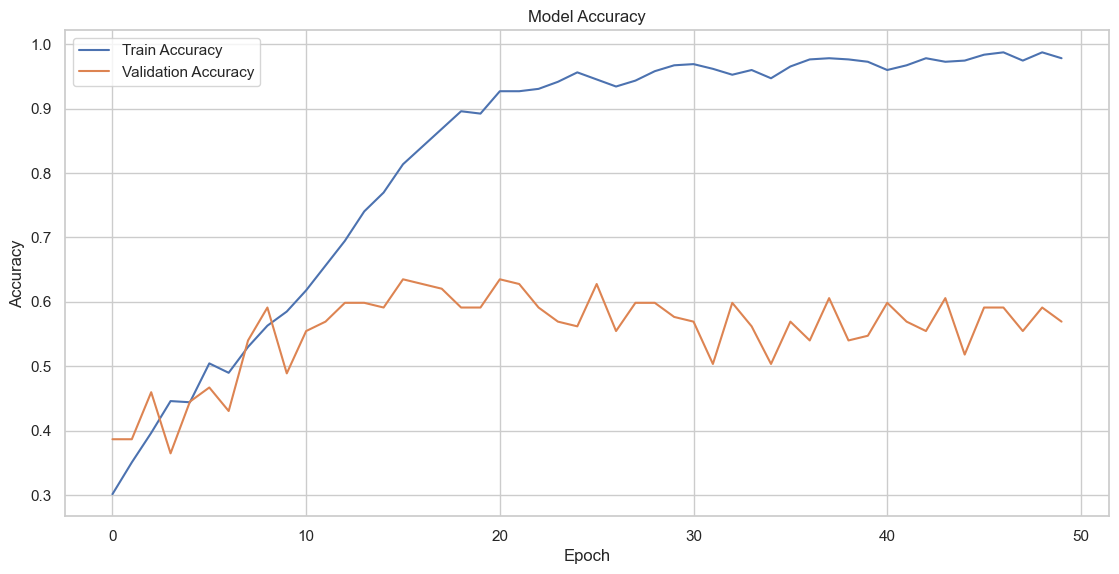

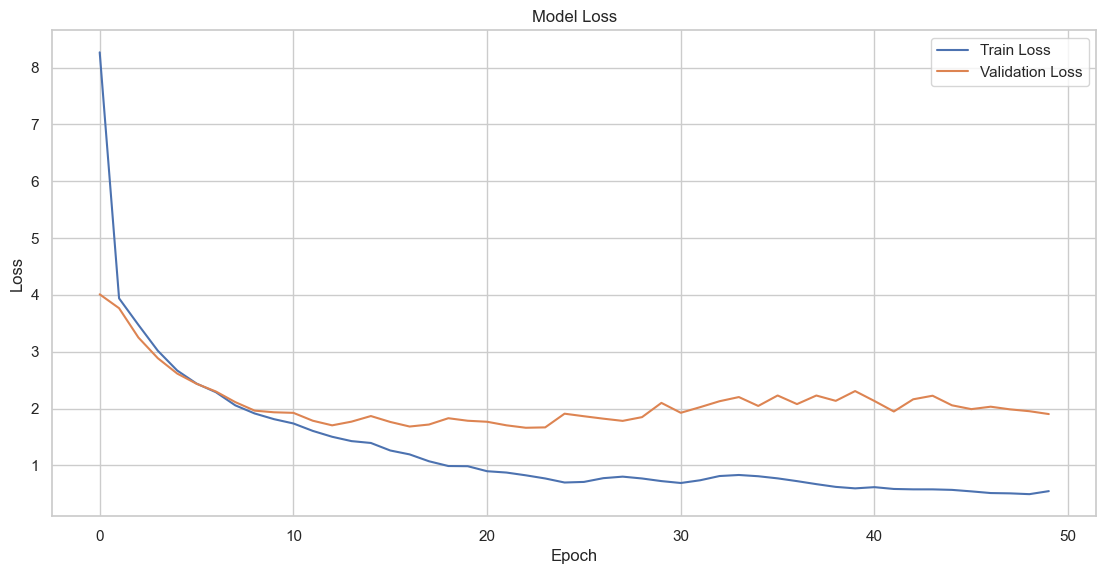

In [23]:
import matplotlib.pyplot as plt

# Plotting the training and validation accuracy
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plotting the training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()
